In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
# img_test = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration10.jpg')
# plt.imshow(img_test)
# img_shape = img_test.shape
# print(img_shape)

# Caliberating Camera

In [41]:
# Arrays to store object points and image points from all the images.
def caliberate_camera():
    objpoints = []     #3D points in real space world
    imgpoints = []     #2D points in real space world

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32) 
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    for fname in images:
        img = mpimg.imread(fname)
        grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_shape = img.shape
        ret, corners = cv2.findChessboardCorners(grey,(9,6), None)   #9 columns and 6 rows
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape[:2], None, None)  
    return ret, mtx, dist

# Distortion Correction (example)

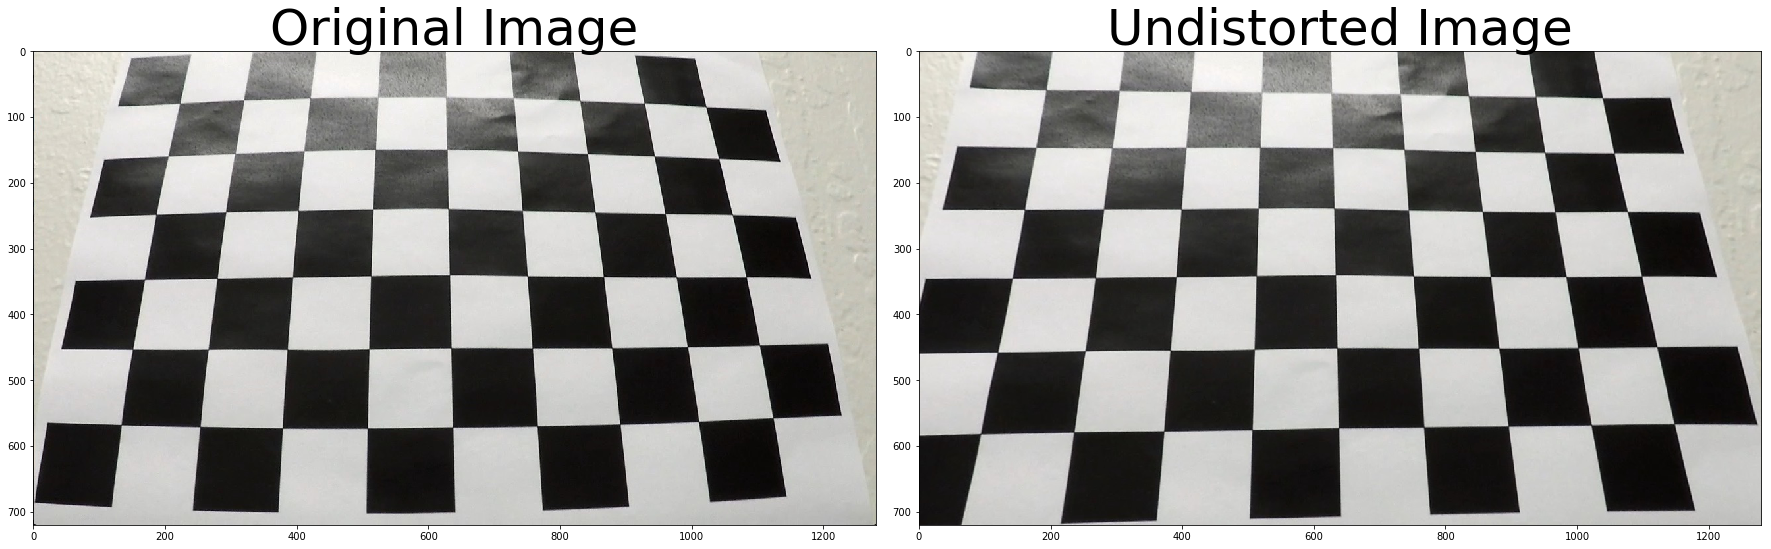

In [42]:
# img = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration3.jpg')
# ret, mtx, dist = caliberate_camera()
# undist = cv2.undistort(img,mtx,dist,None,mtx)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=50)
# ax2.imshow(undist)
# ax2.set_title('Undistorted Image', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.1)

# Gradients and Color Transformation

In [4]:
def abs_sobel_thresh(grey, orient, sobel_kernel, thresh=(0, 255)):
    #grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if(orient == 'x'):
        sobel = cv2.Sobel(grey, cv2.CV_64F,1,0,ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(grey,cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scale_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbbinary = np.zeros_like(scale_sobel)
    sbbinary[(scale_sobel >= thresh[0]) & (scale_sobel <= thresh[1])] = 1
    return sbbinary

def mag_thresh(grey, sobel_kernel, mag_thresh=(0, 255)):
    #grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(grey, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(grey, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    magsobel = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(magsobel)/255
    magsobel = (magsobel/scale_factor).astype(np.uint8)
    sbbinary = np.zeros_like(magsobel)
    sbbinary[(magsobel >= mag_thresh[0]) & (magsobel <= mag_thresh[1])] = 1
    return sbbinary


def dir_threshold(grey, sobel_kernel, thresh=(0.3, np.pi/2)):
    #grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(grey, cv2.CV_64F, 1 ,0, ksize = sobel_kernel)
    sobely = cv2.Sobel(grey, cv2.CV_64F, 0 ,1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgradir = np.arctan2(abs_sobely,abs_sobelx)
    sbbinary = np.zeros_like(absgradir)
    sbbinary[(absgradir >= thresh[0]) & (absgradir <= thresh[1])] = 1
    return sbbinary


def img_threshold(image):
    ret, mtx, dist = caliberate_camera()
    img = np.copy(image)
    img = cv2.undistort(img,mtx,dist,None,mtx)
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    ksize = 15
    gradx = abs_sobel_thresh(grey, orient='x', sobel_kernel=ksize, thresh=(20, 120))
    grady = abs_sobel_thresh(grey, orient='y', sobel_kernel=ksize, thresh=(20, 120))
    mag_binary = mag_thresh(grey, sobel_kernel=ksize, mag_thresh=(100, 120))
    dir_binary = dir_threshold(grey, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_thresh = (150,255)

    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined_condition = np.zeros_like(combined)
    combined_condition[(s_binary == 1) | (combined == 1)] = 1

    return combined_condition    

# Test_images -> Binary Images

In [44]:
# images = glob.glob('test_images/*.jpg')
# n_images = len(images)
# plt.figure(figsize=(15,5*n_images))
# img_ct = 0
# for fname in images:
#     img = mpimg.imread(fname)
#     img=cv2.undistort(img, mtx, dist, None, mtx)
#     plt.subplot(n_images,2,img_ct*2+1)
#     plt.imshow(img)
#     img_mask = img_threshold(img) 
#     plt.subplot(n_images,2,img_ct*2+2)
#     plt.imshow(img_mask, cmap='gray')
#     #plt.imshow(img_mask)
#     img_ct += 1

# perspective transform

In [51]:
def per_transform(image):
    img = np.copy(image)
    src_bottom_left = [220,720]
    src_bottom_right = [1120, 720]
    src_top_left = [570, 470]
    src_top_right = [722, 470]
    
    src = np.float32([src_bottom_left,src_bottom_right,src_top_left,src_top_right])
    
    pts = np.array([src_bottom_left,src_bottom_right,src_top_right,src_top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=10)


    dest_bottom_left = [320,720]
    dest_bottom_right = [920,720]
    dest_top_left = [320,1]
    dest_top_right = [920,1]
    
    dst = np.float32([dest_bottom_left,dest_bottom_right,dest_top_left,dest_top_right])
    
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size,flags = cv2.INTER_LINEAR)
    
#     pts1 = np.array([dest_bottom_left,dest_bottom_right,dest_top_right,dest_top_left], np.int32)
#     pts1 = pts1.reshape((-1,1,2))
#     copy1 = warped.copy()
#     cv2.polylines(copy1,[pts1],True,(255,0,0), thickness=3)
    
    #return copy, warped
    return warped,M


# Example of Perspective Transform (Bird's Eye View)

In [52]:
# images = glob.glob('test_images/*.jpg')
# n_images = len(images)
# plt.figure(figsize=(15,5*n_images))
# img_ct = 0
# for fname in images:
#     img = mpimg.imread(fname)
#     img1,_ = per_transform(img)
#     plt.subplot(n_images,2,img_ct*2+1)
#     plt.imshow(img)
#     plt.subplot(n_images,2,img_ct*2+2)
#     plt.imshow(img1, cmap='gray')
#     img_ct += 1

# Finding the Lane (sliding window)

In [53]:
def find_lane_pixels(binary_warped):
    #Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis = 0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,150,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,150,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img



def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    #print(left_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [150, 0, 0]
    out_img[righty, rightx] = [0, 0, 100]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fit,right_fit,left_fitx,right_fitx


# Example Lane finding

In [65]:
# img = mpimg.imread('test_images/test6.jpg')
# ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# thresh_binary = img_threshold(img)
# binary_warped,_ = per_transform(thresh_binary)
# out_img,left_fit,right_fit,left_fitx,right_fitx = fit_polynomial(binary_warped)

# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')

# plt.imshow(out_img)

# Finding the Lines: Search from Prior


In [58]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty


def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
    left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result,left_fit,right_fit,left_fitx,right_fitx

Finding the Lines: Search from Prior

In [60]:
# img = mpimg.imread('test_images/straight_lines1.jpg')
# thresh_binary = img_threshold(img)
# binary_warped,_ = per_transform(thresh_binary)
# out_img,left_fit,right_fit,_,_ = fit_polynomial(binary_warped)
# result,_,_,_,_ = search_around_poly(binary_warped)
# plt.imshow(result)

# Calculate Curvature

In [12]:

def measure_curvature_real(binary_warped ):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    _,left_fit,right_fit,left_fitx,right_fitx = fit_polynomial(binary_warped)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    
    left_curverad = (1+(2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5 / (2*left_fit_cr[0])
    right_curverad = (1+(2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5 / (2*right_fit_cr[0])
    
    # Calculate vehicle center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Lane center as mid of left and right lane bottom                        
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    if center < 0:
        position = "left"
    else:
        position = "right"
    center = "Vehicle is {:.2f}m {}".format(center, position)
    left_curverad = "left Curvature is: {}".format(left_curverad)
    right_curverad = "left Curvature is: {}".format(right_curverad)
    return left_curverad, right_curverad, center

Drawing Lines in Image

In [68]:
def wrapback(image,warped,M,left_fitx,right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    Minv = np.linalg.inv(M)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    return result

# Plotting radius of Curvature and vehicle distance from centre

In [14]:
def write_data(img_lane,binary_warped):
    img = np.copy(img_lane)
    left_curverad, right_curverad, center = measure_curvature_real(binary_warped)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img,left_curverad,(40,70), font, 1.5,(200,255,150),2,cv2.LINE_AA)
    cv2.putText(img,right_curverad,(40,130), font, 1.5,(200,255,150),2,cv2.LINE_AA)
    cv2.putText(img,center,(40,190), font, 1.5,(200,255,150),2,cv2.LINE_AA)
    #plt.imshow(img)
    return img
    

# Example of drawing Lines

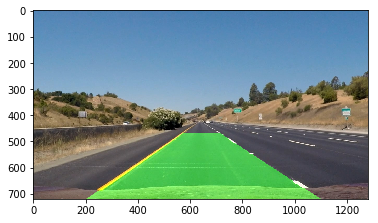

In [69]:
img = mpimg.imread('test_images/straight_lines1.jpg')

thresh_binary = img_threshold(img)
binary_warped,M = per_transform(thresh_binary)
out_img,left_fit,right_fit,left_fitx,right_fitx = fit_polynomial(binary_warped)

res1 = wrapback(img,binary_warped,M,left_fitx,right_fitx)
plt.imshow(res1)

In [16]:
# t = write_data(res1, binary_warped)
# plt.imshow(t)

# PIPELINE

In [17]:
def process_image(image):
    thresh_binary = img_threshold(image)
    binary_warped,M = per_transform(thresh_binary)
    out_img,left_fit,right_fit,left_fitx,right_fitx = fit_polynomial(binary_warped)
    res1 = wrapback(image,binary_warped,M,left_fitx,right_fitx)
    t = write_data(res1, binary_warped)
    return t

# pipeline on all images

In [38]:
images = glob.glob('test_images/*.jpg')
# n_images = len(images)
# plt.figure(figsize=(15,5*n_images))
# img_ct = 0
# for fname in images:
#     img = mpimg.imread(fname)
#     img1 = process_image(img)
#     plt.subplot(n_images,2,img_ct*2+1)
#     plt.imshow(img)
#     plt.subplot(n_images,2,img_ct*2+2)
#     plt.imshow(img1)
#     img_ct += 1

#output images


# i = 1
# for image_file in images:
#     image1 = mpimg.imread(image_file)
#     final_image = process_image(image1)
#     #plt.imshow(image_file)
#     mpimg.imsave('output_images/'+"file"+str(i) + ".jpg", final_image)
#     i = i + 1

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

In [23]:
video_output1 = 'harder_challenge_video_output.mp4'
video_input1 = VideoFileClip('harder_challenge_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [1:01:57<00:03,  3.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 58min 11s, sys: 53.4 s, total: 59min 4s
Wall time: 1h 2min 2s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))